In [0]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [0]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)

In [0]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/TaxiFare/train.csv", 
    index_col="tripid"
)
print(df.dtypes)
df.head()

In [0]:
label_df = pd.DataFrame(df['label'])
feature_df = df.drop(columns='label')
feature_df.head()

In [0]:
label_df['label_copy'] = label_df['label']
labels ={"label": {"correct": 1, "incorrect": 0}}
label_df.replace(labels, inplace=True)
label_df.head()

In [0]:
label_df['label'].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [0]:
label_df.drop(columns='label_copy', inplace=True)
label_df.head()

In [0]:
def set_trip_time(df):
    df['pickup_time'] = pd.to_datetime(df['pickup_time'])
    df['drop_time'] = pd.to_datetime(df['drop_time'])
    df['trip_time'] = (df['drop_time'] - df['pickup_time']).dt.total_seconds()
    df.drop(columns=['pickup_time', 'drop_time'], inplace=True)

set_trip_time(feature_df)

In [0]:
def get_distance(lat1, lon1, lat2, lon2):
    # haversine_distance
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   lamb1 = np.radians(lon1)
   lamb2 = np.radians(lon2)

   delta_phi = phi2 - phi1
   delta_lambda = lamb2 - lamb1
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
   return np.round(res, 3)

def set_distance(feature_df):
    distances = []
    for row in feature_df.itertuples(index=False):
        distances.append(get_distance(row.pick_lat, row.pick_lon, row.drop_lat, row.drop_lon))
    
    feature_df['trip_distance'] = distances
    feature_df.drop(columns=['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], inplace=True)

# Calling the set_distance to set a distance column and remove coordinates columns
set_distance(feature_df)

In [0]:

def set_time_error(feature_df):
    time_errors = []
    feature_df['time_error'] = (feature_df['duration'] - feature_df['trip_time'])**2
    #feature_df.drop(columns=['duration', 'trip_time'], inplace=True)

set_time_error(feature_df)

In [0]:
def add_missing_col(df):
    '''
        This function adds an additional binary column to the df based on all
        additional_fare, duration, meter_waiting, meter_waiting_fare, meter_waiting_till_pickup, time_error
        has NaN values
    '''
    df['ismissing'] = np.where(df[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error']].isnull().all(1), 1, 0)

add_missing_col(feature_df)
feature_df.head()

In [0]:
def feature_process(feature_df):
    set_trip_time(feature_df)
    set_distance(feature_df)
    set_time_error(feature_df)
    add_missing_col(feature_df)

In [0]:
(feature_df.shape, label_df.shape)

((17176, 10), (17176, 1))

In [0]:
feature_df.dtypes

additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
fare                         float64
trip_time                    float64
trip_distance                float64
time_error                   float64
ismissing                      int64
dtype: object

In [0]:
feature_df.isnull().sum()

additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
fare                         137
trip_time                      0
trip_distance                  0
time_error                   202
ismissing                      0
dtype: int64

# Visualizing Data


In [0]:
%%script false --no-raise-error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

imputer = SimpleImputer()
data = imputer.fit_transform(feature_df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

temp_df = pd.DataFrame({'x': pca_result[:,0], 'y': pca_result[:,1], 'label': label_df['label']})

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(temp_df.shape[0])

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=temp_df,
    legend="full",
    alpha=0.6
)

# Outlier Handling

## Visualizing Boxplots

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


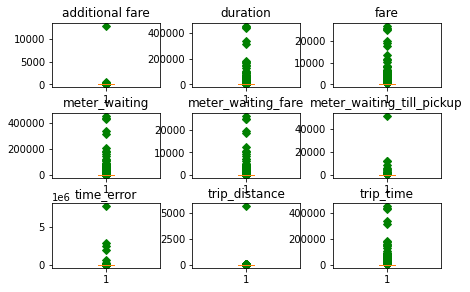

<Figure size 720x720 with 0 Axes>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

columns = feature_df.columns
simple_imputer = SimpleImputer(strategy='median')
data = simple_imputer.fit_transform(feature_df)
data = pd.DataFrame(data=data, columns=columns)
fig, axs = plt.subplots(3,3)

axs[0,0].boxplot(data['additional_fare'], 0, 'gD')
axs[0,0].set_title('additional fare')

axs[0,1].boxplot(data['duration'], 0, 'gD')
axs[0,1].set_title('duration')

axs[0,2].boxplot(data['fare'], 0, 'gD')
axs[0,2].set_title('fare')

axs[1,0].boxplot(data['meter_waiting'], 0, 'gD')
axs[1,0].set_title('meter_waiting')

axs[1,1].boxplot(data['meter_waiting_fare'], 0, 'gD')
axs[1,1].set_title('meter_waiting_fare')

axs[1,2].boxplot(data['meter_waiting_till_pickup'], 0, 'gD')
axs[1,2].set_title('meter_waiting_till_pickup')

axs[2,0].boxplot(data['time_error'], 0, 'gD')
axs[2,0].set_title('time_error')

axs[2,1].boxplot(data['trip_distance'], 0, 'gD')
axs[2,1].set_title('trip_distance')

axs[2,2].boxplot(data['trip_time'], 0, 'gD')
axs[2,2].set_title('trip_time')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

plt.figure(figsize=(10,10))

plt.show()

## Z-Score

In [0]:
from scipy import stats
from sklearn.impute import SimpleImputer

columns = feature_df.columns
simple_imputer = SimpleImputer(strategy='median')
data = simple_imputer.fit_transform(feature_df)
data = pd.DataFrame(data=data, columns=columns)

z = np.abs(stats.zscore(data.drop(columns='ismissing')))
print(z)

outliers = np.where(z > 3)[0]
print("\nNumber of outliers = {}\n".format(len(set(outliers))))

print(outliers)

[[0.03233882 0.10662331 0.07075185 ... 0.10787629 0.00545727 0.02238322]
 [0.03233882 0.11195012 0.07187466 ... 0.11528258 0.03929498 0.02111593]
 [0.03233882 0.07528187 0.06775771 ... 0.07825113 0.03363375 0.0221894 ]
 ...
 [0.03233882 0.17735835 0.07661538 ... 0.18193918 0.08862708 0.01503293]
 [0.03233882 0.10365021 0.06339126 ... 0.10787629 0.04601363 0.01808934]
 [0.03233882 0.17748222 0.07511831 ... 0.18193918 0.0637518  0.01570385]]

Number of outliers = 118

[   20    30    74    74    74    74    74   280   280   280   280   280
   410   467   467   467   467   467   486   694   694   694   694   694
   920  1194  1194  1194  1732  1732  1732  1732  1732  1761  1765  1885
  1885  1885  1885  1885  1924  1996  1996  1996  1996  1996  2042  2086
  2115  2632  2632  2632  2632  2632  2847  2955  3031  3031  3031  3031
  3031  3067  3067  3067  3067  3365  3365  3365  3365  3365  3365  3389
  3389  3389  3389  3389  3397  3397  3397  3397  3397  3549  3572  3572
  3572  3572  3572

In [0]:
data.shape

(17176, 10)

In [0]:
data = data.drop(outliers)
data.shape

(17058, 10)

In [0]:
qwe = np.where(label_df.loc[label_df.index[outliers]]['label']==0)
len(set(qwe[0]))

268

In [0]:
feature_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,trip_time,trip_distance,time_error,ismissing
count,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17039.000000,17176.000000,17176.000000,1.697400e+04,17176.000000
mean,13.719651,1702.858077,629.074231,32.057666,112.466832,312.655466,1713.929902,4.858258,1.551730e+03,0.011761
std,98.975052,8120.160818,8063.260669,465.483573,442.054812,605.300565,8101.459112,43.015847,6.747195e+04,0.107810
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,125.515000,540.000000,1.486000,6.400000e+01,0.000000
50%,10.500000,1009.500000,123.000000,0.116600,73.000000,211.180000,1020.000000,3.218000,3.240000e+02,0.000000
75%,10.500000,1803.000000,351.000000,14.341800,144.000000,366.465000,1800.000000,6.161250,9.000000e+02,0.000000
max,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,26945.990000,453840.000000,5609.521000,7.667361e+06,1.000000


In [0]:
data.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,trip_time,trip_distance,time_error,ismissing
count,17058.000000,17058.000000,17058.000000,17058.000000,17058.000000,17058.000000,17058.000000,17058.000000,17058.000000,17058.000000
mean,12.924170,1375.349367,318.276586,14.173981,104.997362,284.680186,1383.499824,4.482866,603.576386,0.011549
std,12.569029,1348.724111,678.141600,38.507518,118.720299,242.299795,1360.800959,4.378016,814.831309,0.106846
min,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.500000,551.000000,33.000000,0.000000,26.000000,125.752500,540.000000,1.487000,64.000000,0.000000
50%,10.500000,1009.500000,123.000000,0.116600,73.000000,211.180000,1020.000000,3.212000,324.000000,0.000000
75%,10.500000,1767.750000,341.000000,13.581707,142.000000,361.015000,1800.000000,6.133000,900.000000,0.000000
max,221.000000,23860.000000,23326.000000,1302.060600,1427.000000,2112.970000,23820.000000,45.027000,47089.000000,1.000000


In [0]:
def remove_outliers(xdf, ydf):
    columns = xdf.columns
    index = xdf.index.values
    simple_imputer = SimpleImputer(strategy='median')
    data = simple_imputer.fit_transform(xdf)
    xdf = pd.DataFrame(data=data, columns=columns, index=index)
    xdf.index.name = 'tripid'
    z = np.abs(stats.zscore(xdf.drop(columns='ismissing')))
    outliers = np.where(z > 3)[0]
    xdf = xdf.drop(xdf.index[outliers])
    ydf = ydf.drop(ydf.index[outliers])

    return (xdf, ydf)

print("Before: {}|{}".format(feature_df.shape, label_df.shape))
feature_df, label_df = remove_outliers(feature_df, label_df)
print("After: {}|{}".format(feature_df.shape, label_df.shape))

Before: (17176, 10)|(17176, 1)
After: (17058, 10)|(17058, 1)


In [0]:
label_df['label'].value_counts()
# Here 82 incorrect labeled records has been deleted as outliers

1    15459
0     1599
Name: label, dtype: int64

## Feature Coorelation

Text(0, 0.5, 'Pearson Coeerelation')

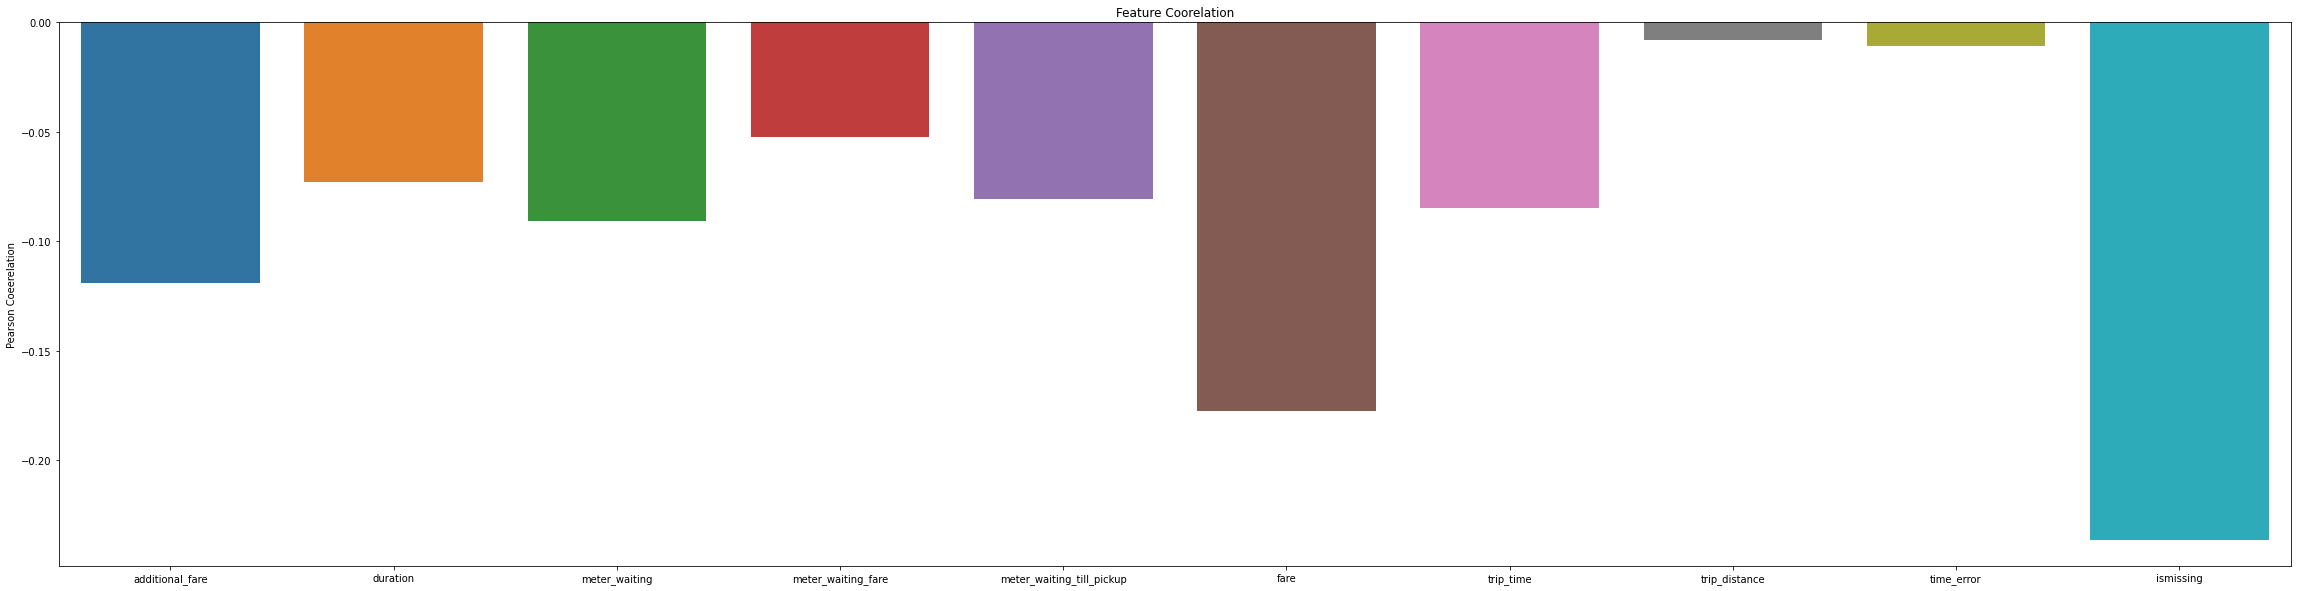

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

corr_df = feature_df.copy()
columns = corr_df.columns

cor = []
for col in columns:
    cor.append(corr_df[col].corr(label_df['label'], method="pearson"))

plt.figure(figsize=(40,10))
plt.title("Feature Coorelation")
sns.barplot(x=columns, y=cor)
plt.ylabel("Pearson Coeerelation")

# Building Models

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

## Setting-up the Pre-Processor

In [0]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)

# SimpleImputer(strategy='median', add_indicator=False) - RandomForest model
# SimpleImputer(strategy='median', add_indicator=True) - LogisticRegression
# SimpleImputer(strategy='most_frequent', add_indicator=True) -XGBClassifier
preprocessor = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median')), #, add_indicator=True
    ('scaler', MinMaxScaler())
])

## Selecting the best model

In [0]:
%%script false --no-raise-error
models = [
    XGBClassifier(max_depth=7, learning_rate=0.01, n_estimators=500, eval_metric='rmse') #, objective='binary:hinge'
    #RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6),
    #LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
    #MultinomialNB(),
    #BernoulliNB(),
    #LogisticRegression(random_state=0),
    #SGDClassifier(),
    #LinearSVC()
]

processed_models = {}
for model in models:
    name = model.__class__.__name__
    processed_models[name] = Pipeline([("preprocessor", preprocessor),
                                      ("estimator", model)])
    
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for (name, model) in processed_models.items():
  f1_scores = cross_val_score(model, feature_df, label_df.label, scoring='f1_macro', cv=CV)
  for fold_idx, f1 in enumerate(f1_scores):
    entries.append((name, fold_idx, f1))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_score'])

print(cv_df)
print(cv_df.groupby('model_name').f1_score.mean())

## Hyper-Parameter Tuning

## Grid Search

In [0]:
%%script false --no-raise-error
# RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6, n_jobs=-1)
# LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
cross_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", XGBClassifier(booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae')),
])

# estimator parameter tuning - Random Forest
criterion = ['gini', 'entropy']
n_estimators = [100, 200, 300, 50]
max_depth = [3, 5, 10, 15]
max_features = [5, 'log2', 'auto']
min_impurity_decrease = [0, 0.2, 0.5, 1.0]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]

param_grid1 = dict(estimators__criterion =criterion,
                  estimators__n_estimators =n_estimators,
                  estimators__max_depth=max_depth,
                  estimators__max_features =max_features,
                  estimators__min_impurity_decrease=min_impurity_decrease,
                  estimators__class_weight=class_weight)

# estimator parameter tuning - Linear Regression
penalty = ['l1', 'l2'] # , 'elasticnet'
C = [0.001, 0.01, 0.1, 1, 10, 100]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [100, 200, 300]

param_grid2 = dict(estimators__penalty = penalty,
                  estimators__C = C,
                  estimators__max_iter = max_iter,
                  estimators__solver = solver,
                  estimators__class_weight=class_weight)

# estimator parameter tuning - XGBoost
booster = ['gbtree', 'dart']
max_depth = [5, 8, 10]
learning_rate = [0.01, 0.05, 0.1, 0.4]
n_estimators = [500, 800, 1000]
eval_metric = ['rmse', 'mae', 'logloss']
objective = ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge']

param_grid3 = dict(estimators__booster = booster,
                   estimators__max_depth = max_depth,
                   estimators__learning_rate = learning_rate,
                   estimators__n_estimators = n_estimators,
                   estimators__eval_metric = eval_metric,
                   estimators__objective = objective)

# preprocessor parameter tuning
strategy = ['mean', 'median', 'most_frequent']
indicator = [True, False]
param_grid4 = dict(preprocessor__simple_imputer__strategy = strategy,
                   preprocessor__simple_imputer__add_indicator = indicator)

X_trainc, X_evalc, y_trainc, y_evalc = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

grid = GridSearchCV(estimator=cross_pipeline,
                    param_grid=param_grid4,
                    scoring='f1_macro',
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_trainc, y_trainc)

print("Model: Random Forest")
print("Best param: ",grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
#print(cross_pipeline.get_params().keys())

# Random Search

In [0]:
%%script false --no-raise-error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cross_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", XGBClassifier(
                      silent=True, nthread=6, tree_method='hist', eval_metric='auc')),
])

# estimator parameter tuning - XGBoost
booster = ['gbtree', 'dart']
max_depth = [4, 5, 6, 8, 10, 12]
learning_rate = [0.01, 0.03, 0.05, 0.1, 0.2]
n_estimators = [500, 800, 1000]
eval_metric = ['rmse', 'mae', 'logloss']
objective = ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge']

param_grid1 = dict(estimators__booster = booster,
                   estimators__max_depth = max_depth,
                   estimators__learning_rate = learning_rate,
                   estimators__n_estimators = n_estimators,
                   estimators__eval_metric = eval_metric,
                   estimators__objective = objective)

param_grid2={
  "estimators__learning_rate"    : [ 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 ] ,
  "estimators__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
  "estimators__min_child_weight" : [ 1, 3, 5, 7 ],
  "estimators__subsample"        : [0.8, 0.9, 1.0],
  "estimators__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
  "estimators__colsample_bytree" : [ 0.7, 0.8, 0.9, 1 ]
 }

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

random_grid = RandomizedSearchCV(estimator=cross_pipeline, 
                                 param_distributions = param_grid1, 
                                 n_iter=10, 
                                 scoring='f1_macro', 
                                 n_jobs=4, 
                                 cv=skf.split(feature_df,label_df), 
                                 verbose=3, 
                                 random_state=1001)

random_grid.fit(feature_df, label_df)
print("Best Params: ", random_grid.best_params_)
print("Best Estimator: ", random_grid.best_estimator_)

In [0]:
random_grid.best_score_

# Train & Evaluation

### Building XGBoostWithEarlyStop esitimators to use with pipelines

In [0]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self, early_stopping_rounds=100, test_size=0.2, 
                 eval_metric=['error','logloss'], **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=6)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_train, y_train),(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [0]:
estimator = XGBoostClassifierWithEarlyStop(max_depth=10, learning_rate=0.01, n_estimators=1000) #, eval_metric='rmse'

In [0]:
#estimator=RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6)
#estimator = LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
# XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse') #, objective='binary:hinge'
#subsample=0.8, min_child_weight=1, max_depth=8/4, learning_rate=0.05, gamma=0.2, colsample_bytree=1, n_estimators=1000, objective='binary:logistic', silent=True, nthread=6, tree_method='hist', eval_metric='auc'

# estimator = XGBClassifier(booster='dart', subsample=0.8, min_child_weight=7, max_depth=15, learning_rate=0.01, gamma=0.4, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logistic',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='auc', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)

# estimator = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse')

# estimator = XGBClassifier(booster='dart', subsample=0.8, min_child_weight=1, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logitraw',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='rmse', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

In [0]:
feature_df.shape

(17058, 10)

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

In [0]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
print(preds)

[0]	validation_0-error:0.045067	validation_0-logloss:0.684871	validation_1-error:0.060805	validation_1-logloss:0.685068
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[1]	validation_0-error:0.044848	validation_0-logloss:0.676854	validation_1-error:0.060805	validation_1-logloss:0.677162
[2]	validation_0-error:0.045614	validation_0-logloss:0.66894	validation_1-error:0.060367	validation_1-logloss:0.669409
[3]	validation_0-error:0.045504	validation_0-logloss:0.661219	validation_1-error:0.061242	validation_1-logloss:0.661809
[4]	validation_0-error:0.045614	validation_0-logloss:0.653662	validation_1-error:0.060805	validation_1-logloss:0.654356
[5]	validation_0-error:0.045614	validation_0-logloss:0.646147	validation_1-error:0.06168	validation_1-logloss:0.647078
[6]	validation_0-error:0.045723	validation_0-logloss:0.638844	validation_1-error:0.061242	validation_1-logloss:0.639

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[8]	validation_0-error:0.045285	validation_0-logloss:0.62478	validation_1-error:0.06168	validation_1-logloss:0.626097
[9]	validation_0-error:0.044957	validation_0-logloss:0.618028	validation_1-error:0.06168	validation_1-logloss:0.619422
[10]	validation_0-error:0.045285	validation_0-logloss:0.611151	validation_1-error:0.062992	validation_1-logloss:0.612794
[11]	validation_0-error:0.044629	validation_0-logloss:0.604642	validation_1-error:0.060367	validation_1-logloss:0.60637
[12]	validation_0-error:0.04441	validation_0-logloss:0.598218	validation_1-error:0.060805	validation_1-logloss:0.600033
[13]	validation_0-error:0.044192	validation_0-logloss:0.591872	validation_1-error:0.060367	validation_1-logloss:0.593804
[14]	validation_0-error:0.044301	validation_0-logloss:0.585541	validation_1-error:0.05993	validation_1-logloss:0.587647
[15]	validation_0-error:0.044301	validation_0-logloss:0.57938	validation_1-error:0.05993	validation_1-logloss:0.581662
[16]	validation_0-error:0.044957	validatio

### Plot error for checking for overfitting

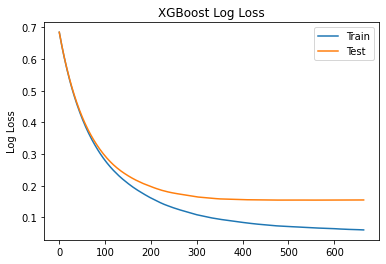

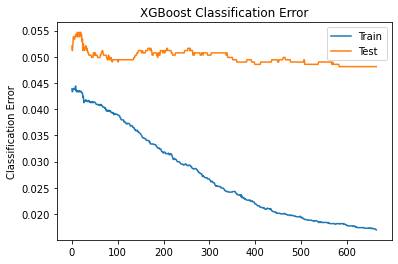

In [0]:

# retrieve performance metrics
results = full_pipeline[-1].estimator.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

## Identify Feature Importances

[0.0470946  0.10631599 0.02840188 0.04584975 0.0228886  0.05372417
 0.10287575 0.05214478 0.01694643 0.523758  ]
{'additional_fare': 0.047094602, 'duration': 0.10631599, 'meter_waiting': 0.028401883, 'meter_waiting_fare': 0.04584975, 'meter_waiting_till_pickup': 0.022888603, 'fare': 0.053724166, 'trip_time': 0.10287575, 'trip_distance': 0.052144777, 'time_error': 0.016946431, 'ismissing': 0.523758}


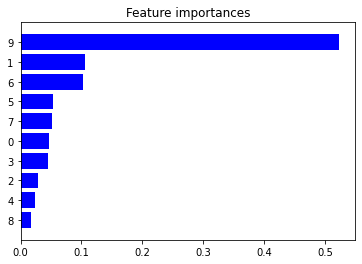

In [0]:
print(full_pipeline[-1].estimator.feature_importances_)
importances = full_pipeline[-1].estimator.feature_importances_
feature_cols = X_train.columns

importance_dict = {}
for i in range(len(feature_cols)):
    importance_dict[feature_cols[i]] = importances[i]

print(importance_dict)

import matplotlib.pyplot as plt
indices = np.argsort(importances)
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="b", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [0]:
estimator = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, reg_lambda=1.7, eval_metric='rmse')

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
print(preds)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1 1 1 ... 1 1 1]


In [0]:
%%script false --no-raise-error
# Submission 3
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9728376035445965
Macro F1_Score: 0.8389292620233442


In [0]:
%%script false --no-raise-error
# Submission 4 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae'
# Imputer - most_frequent
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9719752609199845
Macro F1_Score: 0.8395229839953459


In [0]:
%%script false --no-raise-error
# Submission 4 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae'
# Imputer - median
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9720745965793796
Macro F1_Score: 0.8399301193210346


In [0]:
%%script false --no-raise-error
# Submission 5/6 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=10, learning_rate=0.03, eval_metric='mae'
# Imputer - median 
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9724717473196176
Macro F1_Score: 0.8415658228983875


In [0]:
%%script false --no-raise-error
# Submission xxx - XGB with half of the parameter tuning
# Imputer - median 
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9713020030816641
Macro F1_Score: 0.8294665151676665


In [0]:
%%script false --no-raise-error
# Submission 7 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=10, learning_rate=0.03, eval_metric='mae'
# Outliers handled
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9734496124031007
Macro F1_Score: 0.8409801253504865


In [0]:
%%script false --no-raise-error
# Submission 8 - max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse' with outlier handling
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9736359246740706
Macro F1_Score: 0.8359892330552674


In [0]:
%%script false --no-raise-error
# Submission 9 - objective = 'binary:hinge', max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse' with outlier handling
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

# leaderboard loss from submission 8

F1_Score: 0.9729886726691839
Macro F1_Score: 0.8366554534130022


In [0]:
%%script false --no-raise-error
# Submission 10 - submission 8 without time-error
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9732393005506715
Macro F1_Score: 0.8349219503848648


In [0]:
%%script false --no-raise-error
# Submission 11 - Submission 8 with ismissing column
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#3nd best model

F1_Score: 0.9733539293299864
Macro F1_Score: 0.8336836165496939


In [0]:
# XGBClassifier(booster='dart', subsample=0.8, min_child_weight=1, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logitraw',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='rmse', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)

# Did not submit as with low score
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9721146398140975
Macro F1_Score: 0.8315508821388085


In [0]:
# Submission 13 - submission 11 with learning_rate=0.05, eval_metric='logloss'
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9731245166279968
Macro F1_Score: 0.8348155334231686


In [0]:
# Submission 14 - Submission 13 with reg_lambda=1.5
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#4rd best model

F1_Score: 0.9730304494925085
Macro F1_Score: 0.8340562083528116


In [0]:
# Submission 15 - Submission 11 with reg_lambda=1.7
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#2rd best model

F1_Score: 0.9737451737451738
Macro F1_Score: 0.8357614757614757


Text(0.5, 15.0, 'Predicted')

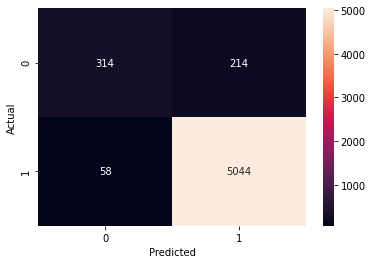

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_eval, preds)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Predicting on Test Data

In [0]:
%%time 

full_pipeline.fit(feature_df, label_df)
None

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 31 s, sys: 66.8 ms, total: 31.1 s
Wall time: 31.1 s


In [0]:
test_features_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/test.csv", 
                               index_col="tripid")

feature_process(test_features_df)
print(test_features_df.shape)
test_features_df.head()

In [0]:
test_features_df.isna().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
fare                         0
trip_time                    0
trip_distance                0
time_error                   0
ismissing                    0
dtype: int64

In [0]:
test_predictions = full_pipeline.predict(test_features_df)
test_predictions

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
submission_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/sample_submission.csv", 
                            index_col="tripid")

In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = test_predictions

submission_df.head()

In [0]:
submission_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/TaxiFare/my_submission.csv', index=True)

In [0]:
!head /content/gdrive/My\ Drive/Colab\ Notebooks/TaxiFare/my_submission.csv

In [0]:
%%script false --no-raise-error
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 